## Speed Measurements

Studying run times of algorithms as game conditions vary.

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime as dt
import networkx as nx
from IPython.display import clear_output
import pickle

# Globals
NODE_COUNT = 50
TURNS_PER_PLAYER = 3
TURNS = TURNS_PER_PLAYER * 2
NODE_RADIUS = 12
SCREEN_SIZE = (800, 600)
DEPTH = 3
GAMES = 3

# Simulation Settings
COAEG = True
ENABLE_VISUAL_VIEW = True
ENABLE_PEEK = True
POST_GAME = True
LOG_SCALE = False
IMPORT = None
EXPORT = None
LAPLACIAN_IMPORT = None
LAPLACIAN_EXPORT = None

# Important Algorithms and Bot Functions
def get_graph_laplacian(edges):
    # Create adjacency matrix
    adj_mat = np.zeros((NODE_COUNT, NODE_COUNT))
    for i, j in edges:
        adj_mat[i, j] = 1
        adj_mat[j, i] = 1

    # Get degree matrix
    deg_mat = np.diag(np.sum(adj_mat, axis=1))

    return deg_mat - adj_mat  # Laplacian matrix

def get_influence(graph_laplacian, config):
    """This function takes in the graph Laplacian and the previously
    selected boundary nodes as columns of a matrix with each column
    representing a different boundary node set. It returns the influence
    had by each team in the graph.

    Args:
        graph_laplacian ((n,n) ndarray): The graph Laplacian for the given graph

        config (ndarray): The previously selected boundary nodes in sequential order alternating team

    Returns:
        influence ((2,) ndarray): The influence of each team in the graph
    """

    # Get all boundary nodes for team 1 and create an n length array with 1's in those positions
    config = config.astype(int)
    team_1_nodes = config[1::2]
    team_1_bd = np.zeros(graph_laplacian.shape[0]).astype(int)
    team_1_bd[team_1_nodes] = 1

    # Create the Laplacian of the subgraph
    compliment = np.setdiff1d(np.arange(graph_laplacian.shape[0]), config)
    lsc = graph_laplacian[compliment, :][:, compliment]

    # Compute the boundary block matrix
    b = graph_laplacian[compliment, :][:, config]

    # Calculate the influence using least squares to solve the linear system
    influence_1 = np.linalg.lstsq(lsc, -b @ team_1_bd[config], rcond=None)[0].sum()

    # Add influence of each node in the specific boundary set
    influence_1 += team_1_bd.sum()

    # Calculate influence of team 0 using same approach as above
    team_0_nodes = config[0::2]
    team_0_bd = np.zeros(graph_laplacian.shape[0]).astype(int)
    team_0_bd[team_0_nodes] = 1
    influence_0 = np.linalg.lstsq(lsc, -b @ team_0_bd[config], rcond=None)[0].sum()
    influence_0 += team_0_bd.sum()

    '''
    More efficient way to calculate influece_0, but it only works if network is connected
    
    # Calculate the influence of the other team
    influence_0 = graph_laplacian.shape[0] - influence_1
    '''

    return np.array((influence_0, influence_1))

def gui_easy_opponent(graph_laplacian, config, depth):
    return np.random.choice(np.setdiff1d(np.arange(graph_laplacian.shape[0]), config))

def gui_greedy_algorithm(graph_laplacian, config, depth):
    """This function takes in the graph Laplacian, the previously
    selected boundary nodes as an iterable, and the number of nodes
    per team. It returns the best node to add to the boundary set
    using the greedy algorithm.

    Args:
        graph_laplacian ((n,n) ndarray): The graph Laplacian for
        the given graph

        config (ndarray): The previously selected boundary nodes
        in sequential order alternating team

        nodes_per_team (int): The number of nodes per team

    Returns:
        best_node (int): The best node to add to the boundary set
    """

    if type(config) is not np.ndarray:
        config = np.array(config)

    turn = config.shape[0] % 2
    nodes = np.arange(graph_laplacian.shape[0])
    nodes_remaining = np.setdiff1d(nodes, config)

    best_node = None
    best_value = -np.inf

    if config.shape[0] == 0:  # First move
        return np.argmax(np.diag(graph_laplacian))

    # elif config.shape[0] >= nodes_per_team * 2:  # Game is over
    #     return None

    else:  # Not first move
        for n in nodes_remaining:  # Check each node to see which one is best
            new_val = get_influence(graph_laplacian, np.append(config, n).astype(int))[turn]
            if new_val > best_value:
                best_value = new_val
                best_node = n

    return best_node

def gui_minimax_algorithm_opt(graph_laplacian, config, depth=3):
    """ Optimized using alpha-beta pruning.

    This function takes in the graph Laplacian, the previously
    selected boundary nodes as an iterable, and the number of nodes
    per team. It returns the best node to add to the boundary set
    using the minimax algorithm.

    Args:
        graph_laplacian ((n,n) ndarray): The graph Laplacian for
        the given graph

        config (ndarray): The previously selected boundary nodes
        in sequential order alternating team

        nodes_per_team (int): The number of nodes per team

    Returns:
        best_node (int): The best node to add to the boundary set
    """

    def minimax_recursive_step(config, depth, alpha, beta):

        if type(config) is not np.ndarray:
            config = np.array(config)

        turn = config.shape[0] % 2  # 0 for maximizing team, 1 for minimizing team

        if depth == 0 or config.shape[0] >= TURNS:
            return get_influence(graph_laplacian, config.astype(int))[0], None

        nodes_remaining = np.setdiff1d(np.arange(graph_laplacian.shape[0]), config)

        if turn == 0:  # Maximizing team
            value = -np.inf
            best_node = None
            for node in nodes_remaining:
                new_value, _ = minimax_recursive_step(np.append(config, node), depth - 1, alpha, beta)
                # if the value is updated, update the best move
                if value < new_value:
                    value = new_value
                    best_node = node
                # Alpha-Beta Pruning
                if value > beta:
                    break
                alpha = max(alpha, value)
            return value, best_node

        if turn == 1:  # Minimizing team
            value = np.inf
            best_node = None
            for node in nodes_remaining:
                new_value, _ = minimax_recursive_step(np.append(config, node), depth - 1, alpha, beta)
                # if the value is updated, update the best move
                if value > new_value:
                    value = new_value
                    best_node = node
                # Alpha-Beta Pruning
                if value < alpha:
                    break
                beta = min(beta, value)
            return value, best_node

    return minimax_recursive_step(config, depth, -np.inf, np.inf)[1]

# Graph Generation Algorithms
def random_proxmity(N, SCREEN_SIZE):
    nodes = random_node_placement(N, SCREEN_SIZE)
    edge_threshold = np.linalg.norm(np.array(SCREEN_SIZE)) * 0.095  #Set edge threshold as a fraction of the diagonal
    edges = [[i, j] for i in range(N) for j in range(i+1, N) if np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j])) < edge_threshold]
    return nodes, edges

def random_node_placement(N, SCREEN_SIZE):
    X_MARGIN = int(SCREEN_SIZE[0] * 0.14)
    Y_MARGIN = int(SCREEN_SIZE[1] * 0.16)
    nodes = []
    while len(nodes) < N:
        new_node = [random.randint(X_MARGIN, SCREEN_SIZE[0] - X_MARGIN), random.randint(Y_MARGIN, SCREEN_SIZE[1] - Y_MARGIN)]
        if all(np.linalg.norm(np.array(new_node) - np.array(existing_node)) > 2 * NODE_RADIUS for existing_node in nodes): 
            nodes.append(new_node)
    return nodes

##### Visual and Simulation Helpers

In [5]:
def draw_graph(nodes, edges, config, title, game_nbr, post_game):
    plt.clf()
    node_count = len(nodes)
    pick_order = {}
    node_colors = ["purple" for _ in range(node_count)]
    G = nx.Graph()
    G.add_nodes_from(range(0, node_count))
    G.add_edges_from(edges)
    
    if post_game:
        for i, pick in enumerate(config):
            pick_order[pick] = i + 1
        switch = True
        for node in config:
            if switch:
                node_colors[node] = "red"
            else:
                node_colors[node] = "blue"
            switch = not switch
    
    plt.figure(2, figsize=(8, 6))
    plt.title(f"{title} - Game #{game_nbr}")
    nx.draw(G, pos=nodes, node_color=node_colors, with_labels=post_game, labels=pick_order)
    plt.show()

def create_visual(vn, sim_dict):
    plt.clf()
    fig, ax = plt.subplots()
    tm = sim_dict["tm"]
    title = sim_dict["ti"]

    if vn == 1:
        cmap = plt.get_cmap('coolwarm')
        turn_labels = [f"{i + 1}" for i in range(TURNS)]
        values = np.array(np.average(tm, axis=0)).flatten()
        norm_values = (values - min(values)) / (max(values) - min(values))
        ax.bar(turn_labels, values, color=cmap(norm_values))
        ax.set_xlabel("Turn #")
        ax.set_ylabel("Average Time (sec)")
        ax.set_xticks(np.arange(1, TURNS + 1, 1))
        ax.set_title(f"{title} - Average Turn Time")
    elif vn == 2:
        cmap = plt.get_cmap('viridis')
        turns = [i + 1 for i in range(TURNS)]
        for game in range(GAMES):
            ax.scatter(turns, np.array(tm[game]).flatten(), color=cmap(game / TURNS))
        ax.scatter(turns, np.array(np.average(tm, axis=0)).flatten(), marker="x", color="black")
        ax.set_xlabel("Turn #")
        ax.set_ylabel("Time (sec)")
        ax.set_title(f"{title} - Turn Time")
        ax.set_xticks(np.arange(1, TURNS + 1, 1))
    
    if LOG_SCALE:
        ax.set_yscale('log')
    plt.show()

def create_multi_visual(vn, sim_dict_list):
    plt.clf()
    fig, ax = plt.subplots()

    if vn == 3:
        sim_title_list = [d["ti"] for d in sim_dict_list]
        turn_labels = [f"{i + 1}" for i in range(TURNS)]
        x = np.arange(TURNS)  
        width = 0.25  
        multiplier = 0
        for i, sim in enumerate(sim_dict_list):
            values = np.array(np.average(sim["tm"], axis=0)).flatten()
            offset = width * multiplier
            ax.bar(x + offset, values, width, label=sim_title_list[i])
            multiplier += 1
        ax.set_xticks(x + width, turn_labels)
        ax.set_xlabel("Turn #")
        ax.set_ylabel("Average Time (sec)")
        ax.set_title("Simulation Comparison - Average Turn Time")
        ax.legend(loc='upper right')
    elif vn == 4:
        cmap = plt.get_cmap('tab10')
        sim_title_list = [d["ti"] for d in sim_dict_list]
        turn = [i % TURNS + 1 for i in range(TURNS * GAMES)]
        for i, sim in enumerate(sim_dict_list):
            ax.scatter(turn, np.array(sim["tm"]).flatten(), color=cmap(i), label=sim_title_list[i])
        ax.set_xlabel("Turn #")
        ax.set_ylabel("Time (sec)")
        ax.set_title("Simulation Comparison - Turn Time")
        ax.set_xticks(np.arange(1, TURNS + 1, 1))
        ax.legend(loc='upper right')

    if LOG_SCALE:
        ax.set_yscale('log')
    plt.show()

def move_timer(laplacian, bot):
    move_times = []
    config = []
    for _ in range(TURNS):
        time = dt.now()
        node = bot(laplacian, config, DEPTH)
        move_times.append((dt.now() - time).total_seconds())
        config.append(node)
        
    return move_times, config
    

##### Graph Generation

In [6]:
laplacian_collection = []
node_collection = []
edge_collection = []

def generate_graphs():
    laplacian_collection.clear()
    node_collection.clear()
    edge_collection.clear()
    for _ in range(GAMES):
        nodes, edges = random_proxmity(NODE_COUNT, SCREEN_SIZE)
        laplacian_collection.append(get_graph_laplacian(edges))
        node_collection.append(nodes)
        edge_collection.append(edges)

if LAPLACIAN_IMPORT:
    with open(LAPLACIAN_IMPORT, 'rb') as infile:
        collection = pickle.load(infile)
        laplacian_collection = collection[0]
        node_collection = collection[1]
        edge_collection = collection[2]
        GAMES = len(laplacian_collection)
        NODE_COUNT = len(node_collection[0])
else:
    generate_graphs()
    if LAPLACIAN_EXPORT:
        with open(f"{LAPLACIAN_EXPORT}.pkl", 'wb') as outfile:
            pickle.dump([laplacian_collection, node_collection, edge_collection], outfile)

##### Simulation Function

In [7]:
simulation_collection = []

def run_simulation(sim, alg, title):
    time_collection = []
    config_collection = [[] for _ in range(GAMES)]
    for i, laplacian in enumerate(laplacian_collection):
        time_list, config = sim(laplacian, alg)
        time_collection.append(time_list)
        config_collection[i] = config
        if COAEG:
            clear_output(wait=True)
        print(f"- - - {title} - - -")
        print(f"- GAME #{i + 1} -")
        for i, time in enumerate(time_list):
            print(f"Turn #{i + 1}: {time} seconds")
        print(f"Total Game Time {np.sum(time_collection[-1])} seconds")
        print()

    time_matrix = np.matrix(time_collection)
    simulation_collection.append(
        {
            "ti": title,
            "tm": time_matrix,
            "cc": config_collection.copy(),
            "nc": node_collection.copy(),
            "ec": edge_collection.copy(),
            "lc": laplacian_collection.copy()
        }
    )

##### Simulation Set Up and Running

In [8]:
if IMPORT != None and IMPORT != False:
    if isinstance(IMPORT, list):
        for sim in IMPORT:
            with open(sim, 'rb') as infile:
                simulation_collection.append(pickle.load(infile))
    else:
        with open(IMPORT, 'rb') as infile:
                simulation_collection.append(pickle.load(infile))
    simulation_count = len(simulation_collection)
else:
    ''' &&&&&&&&&&&&&&&&&&& ENTER SIMULATION(S) HERE &&&&&&&&&&&&&&&&&&& '''
    run_simulation(move_timer, gui_minimax_algorithm_opt, "Random Testing")
    ''' &&&&&&&&&&&&&&&&&&& END SIMULATION(S) &&&&&&&&&&&&&&&&&&& '''
    simulation_count = len(simulation_collection)
    if EXPORT != None and EXPORT != False:
        if simulation_count > 1:
            for i in range(simulation_count):
                with open(f"{EXPORT}{i}.pkl", 'wb') as outfile:
                    pickle.dump(simulation_collection[i], outfile)
        else:
            with open(f"{EXPORT}.pkl", 'wb') as outfile:
                    pickle.dump(simulation_collection[0], outfile)
    

- - - Random Testing - - -
- GAME #3 -
Turn #1: 2.458266 seconds
Turn #2: 2.758268 seconds
Turn #3: 2.20621 seconds
Turn #4: 1.849576 seconds
Turn #5: 0.088114 seconds
Turn #6: 0.013689 seconds
Total Game Time 9.374122999999999 seconds



##### Display Visuals

<Figure size 640x480 with 0 Axes>

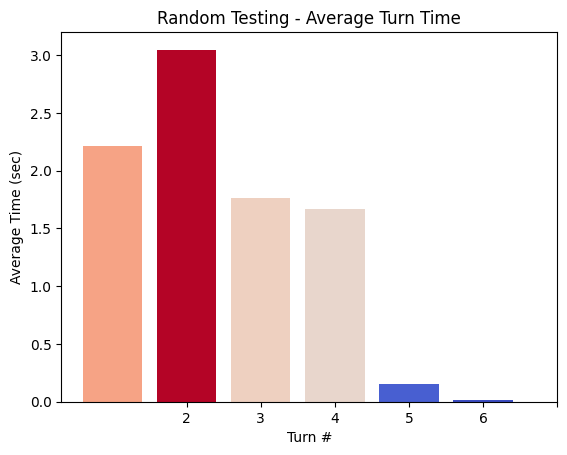

In [9]:
visual_count = 4
multi_switch_pt = 3

"""
Here are the visual options
    Visuals for 1 Simulation:
        (1) Bar chart of average time per turn
        (2) Scatter plot of average time per turn (includes markers for average time)
    
    Visuals for Multiple Simulations:
        (3) Comparison bar chart for average time per time
        (4) Comparison scatter plot of average time per turn

    FLAGS (add after visual number):
        l - makes the visual log scaled
"""

while ENABLE_VISUAL_VIEW:
    visual_code = input("Which visual would you like to view? ")
    
    LOG_SCALE = True if 'l' in visual_code else False
    visual_code = int(visual_code[0])
    if visual_code <= 0 or visual_code > visual_count:
        break
    elif visual_code < multi_switch_pt:
        if simulation_count > 1:
            sim_nbr = int(input("Which simulation would you like to create this visual for? "))
        else: 
            sim_nbr = 1
        clear_output(wait=True)
        create_visual(visual_code, simulation_collection[sim_nbr - 1])
    else:
        if simulation_count > 1:
            clear_output(wait=True)
            create_multi_visual(visual_code, simulation_collection)
        else:
            print("This visualization only works if you performed more than one simulation!")

##### Graph Peek

<Figure size 640x480 with 0 Axes>

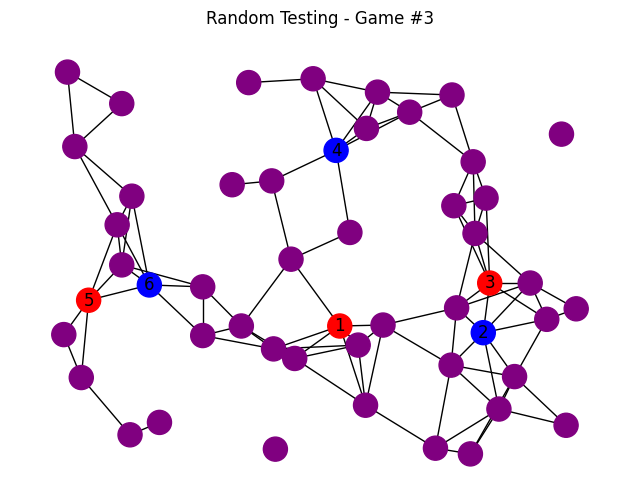

In [10]:
while ENABLE_PEEK:
    if simulation_count > 1:
        sim_nbr = int(input("Which simulation would you like to peek from? "))
        if sim_nbr <= 0 or sim_nbr > simulation_count:
            break
    else:
        sim_nbr = 1
    graph_number = int(input("Which game would you like to view? "))
    if graph_number <= 0 or graph_number > GAMES:
        break
    
    clear_output(wait=True)
    sim = simulation_collection[sim_nbr - 1]
    draw_graph(sim["nc"][graph_number - 1], sim["ec"][graph_number - 1], sim["cc"][graph_number - 1], sim["ti"], graph_number, POST_GAME)